<a href="https://colab.research.google.com/github/nknitin121/Drug_Discovery_Platform/blob/main/DrugDiscovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Run this first if you want to ensure some packages are present.
!pip install -q imbalanced-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/drug_discovery_virtual_screening.csv'

import os
print("File exists:", os.path.exists(DATA_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File exists: True


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
display(df.head())
display(df.dtypes)


Shape: (2000, 17)


,compound_id,protein_id,molecular_weight,logp,h_bond_donors,h_bond_acceptors,rotatable_bonds,polar_surface_area,compound_clogp,protein_length,protein_pi,hydrophobicity,binding_site_size,mw_ratio,logp_pi_interaction,binding_affinity,active
0,CID_00000,PID_361,499.671415,2.487233,1,7,4,113.350817,4.050696,678,6.019657,0.812534,12.512165,0.736978,14.972288,5.996665,0
1,CID_00001,PID_165,436.173570,3.283222,3,4,4,71.981132,3.704408,876,6.447408,0.651417,11.538420,0.497915,21.168271,6.445742,0
2,CID_00002,PID_168,514.768854,NaN,2,11,11,83.936307,1.869610,658,3.925837,0.633467,13.155702,0.782323,9.074061,5.689583,0
3,CID_00003,PID_226,602.302986,3.038058,0,5,5,79.868125,2.451909,312,7.597056,0.513038,12.071822,1.930458,23.080293,6.043438,0
4,CID_00004,PID_224,426.584663,0.659578,2,4,5,88.198676,1.771936,1418,4.249454,0.613571,15.850448,0.300835,2.802846,4.845055,0


,0
compound_id,object
protein_id,object
molecular_weight,float64
logp,float64
h_bond_donors,int64
h_bond_acceptors,int64
rotatable_bonds,int64
polar_surface_area,float64
compound_clogp,float64
protein_length,int64


In [ ]:
# Replace infinities with NaN (prevents seaborn/pandas warnings)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert non-ID object columns to numeric where sensible
id_cols = ['compound_id', 'protein_id']
for col in df.columns:
    if col in id_cols:
        continue
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Missing values before imputation:")
display(df.isnull().sum())


Missing values before imputation:


,0
compound_id,0
protein_id,0
molecular_weight,0
logp,60
h_bond_donors,0
h_bond_acceptors,0
rotatable_bonds,0
polar_surface_area,60
compound_clogp,0
protein_length,0


In [ ]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# keep target 'active' numeric; impute only features (we won't impute active)
features = [c for c in num_cols if c != 'active']

imputer = SimpleImputer(strategy='median')
df[features] = imputer.fit_transform(df[features])

print("Missing values after imputation (should be 0 for numeric features):")
display(df[features].isnull().sum())


Missing values after imputation (should be 0 for numeric features):


,0
molecular_weight,0
logp,0
h_bond_donors,0
h_bond_acceptors,0
rotatable_bonds,0
polar_surface_area,0
compound_clogp,0
protein_length,0
protein_pi,0
hydrophobicity,0


Class distribution (counts and %):
active
0    1392
1     608
Name: count, dtype: int64
active
0    0.696
1    0.304
Name: proportion, dtype: float64


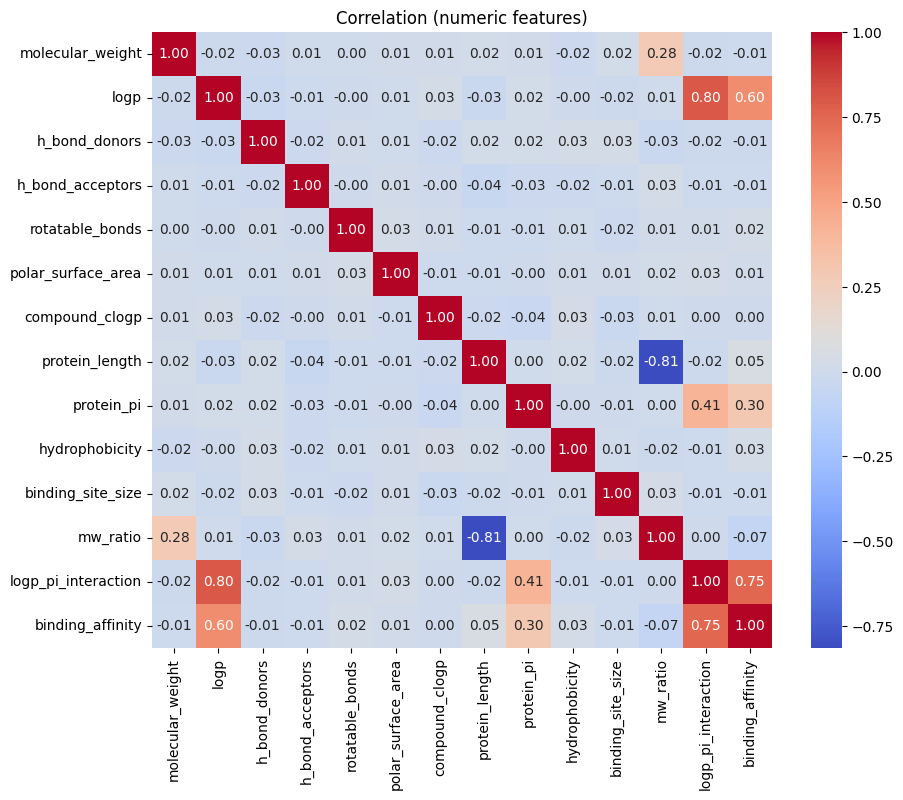

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# class balance
print("Class distribution (counts and %):")
print(df['active'].value_counts())
print(df['active'].value_counts(normalize=True).round(3))

# correlation heatmap (numeric features)
plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation (numeric features)')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Drop ID columns; keep all numeric features except target
X = df.drop(columns = id_cols + ['active'])
y = df['active'].astype(int)

# Stratify to keep class distribution in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 14) Test shape: (400, 14)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, solver='liblinear', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB()
}

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


In [ ]:
results = []

for name, estimator in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', estimator)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # ROC AUC if probabilities available, else set None
    roc = None
    try:
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            roc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
        elif hasattr(pipe.named_steps['clf'], "decision_function"):
            roc = roc_auc_score(y_test, pipe.decision_function(X_test))
    except Exception:
        roc = None

    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc,
        'object': pipe
    })

import pandas as pd
res_df = pd.DataFrame(results).set_index('model').sort_values('f1', ascending=False)
display(res_df[['accuracy','precision','recall','f1','roc_auc']].round(4))


,accuracy,precision,recall,f1,roc_auc
model,,,,,
DecisionTree,1.0000,1.0000,1.0000,1.0000,1.0000
RandomForest,1.0000,1.0000,1.0000,1.0000,1.0000
GradientBoosting,1.0000,1.0000,1.0000,1.0000,1.0000
LogisticRegression,0.9825,0.9752,0.9672,0.9712,0.9991
NaiveBayes,0.9350,0.9068,0.8770,0.8917,0.9847
SVM,0.9350,0.9211,0.8607,0.8898,0.9909
KNN,0.9025,0.9368,0.7295,0.8203,0.9473


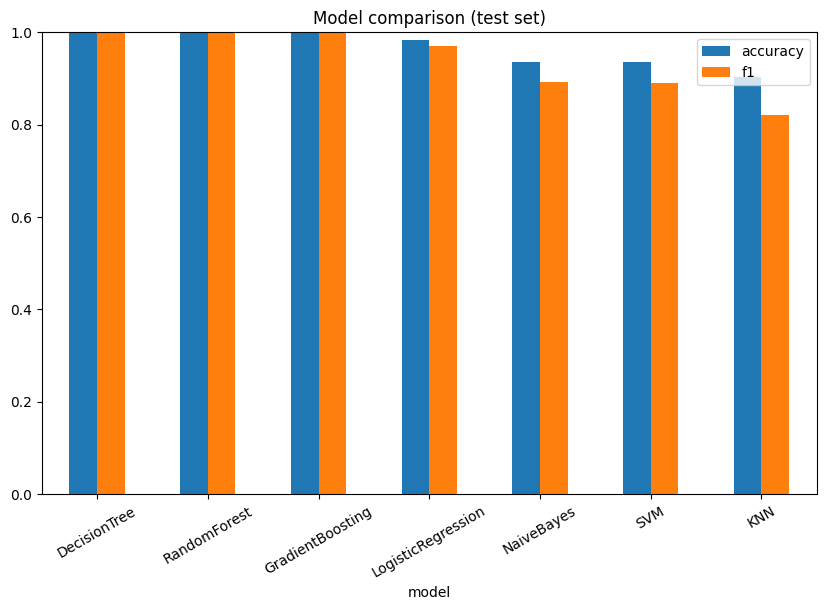

In [ ]:
ax = res_df[['accuracy','f1']].plot.bar(figsize=(10,6))
ax.set_ylim(0,1)
ax.set_title('Model comparison (test set)')
plt.xticks(rotation=30)
plt.show()


Best model: DecisionTree

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       278
           1       1.00      1.00      1.00       122

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



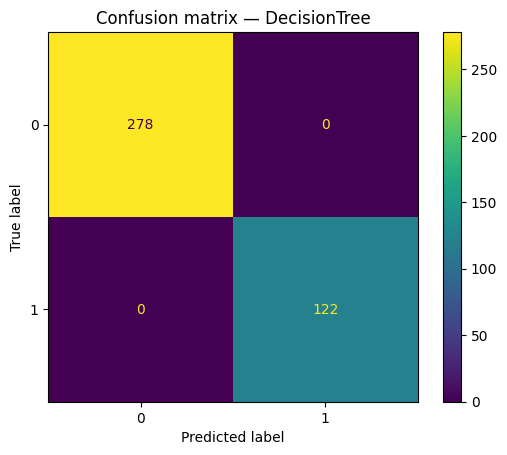

Saved best pipeline to: /content/drive/MyDrive/ai_drug_discovery_best_pipeline.joblib


In [ ]:
# choose best by f1 (you can change criteria)
best_row = res_df.iloc[0]
best_name = best_row.name
best_pipe = best_row['object']

print("Best model:", best_name)
y_pred_best = best_pipe.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred_best, zero_division=0))

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion matrix — {best_name}")
plt.show()

# Save the pipeline to Drive
import joblib
OUT_PATH = '/content/drive/MyDrive/ai_drug_discovery_best_pipeline.joblib'
joblib.dump(best_pipe, OUT_PATH)
print("Saved best pipeline to:", OUT_PATH)


In [ ]:
import joblib
import numpy as np
import pandas as pd

# 1. Apna trained pipeline load karo
MODEL_PATH = '/content/drive/MyDrive/ai_drug_discovery_best_pipeline.joblib'
model = joblib.load(MODEL_PATH)
#
# 2. Ek naya compound ke features banao (sirf numeric features, ID nahi dena)
# Ye values example hain, tum dataset ke pattern ke hisaab se dal sakte ho
new_sample = pd.DataFrame([{
    "molecular_weight": 450.0,
    "logp": 2.8,
    "h_bond_donors": 2,
    "h_bond_acceptors": 5,
    "rotatable_bonds": 4,
    "polar_surface_area": 90.0,
    "compound_clogp": 3.5,
    "protein_length": 700,
    "protein_pi": 6.2,
    "hydrophobicity": 0.65,
    "binding_site_size": 12.0,
    "mw_ratio": 0.75,
    "logp_pi_interaction": 15.0,
    "binding_affinity": 6.0
}])

# 3. Prediction (Active ya Inactive)
prediction = model.predict(new_sample)[0]

# 4. Probability (Inactive vs Active)
if hasattr(model.named_steps['clf'], "predict_proba"):
    prob = model.predict_proba(new_sample)[0]
else:
    prob = [None, None]  # kuch models me prob available nahi hota

print("Prediction (0=Inactive, 1=Active):", prediction)
print(f"Probabilities → Inactive: {prob[0]:.2f}, Active: {prob[1]:.2f}")


Prediction (0=Inactive, 1=Active): 0
Probabilities → Inactive: 1.00, Active: 0.00
